In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a function that takes an image, number of x and y points,
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def my_abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    def scale_sobel(input):
        abs_sobelx = np.absolute(input)
        return np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    scaled_sobel = scale_sobel(sobelx) if orient == 'x' else scale_sobel(sobely)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # plt.imshow(sxbinary, cmap='gray')
    return sxbinary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray)
    plt.show()
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def get_combined(img):
    # Choose a Sobel kernel size
    ksize = 3  # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 255))
    print("mag:")
    plt.imshow(mag_binary)
    plt.show()
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi / 2))
#     plt.imshow(dir_binary)
#     plt.show()
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return  combined

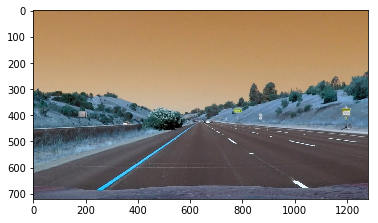

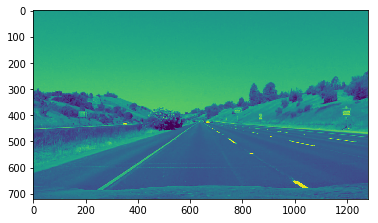

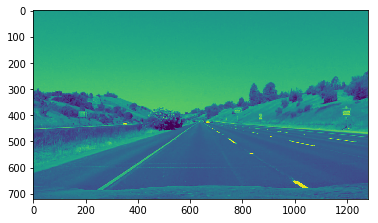

mag:


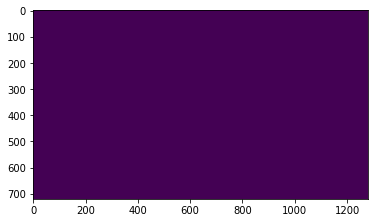

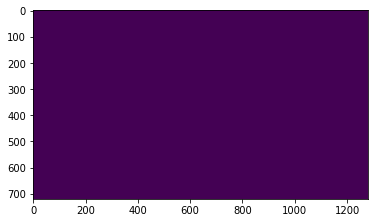

In [10]:
straight = cv2.imread("..\\test_images\\straight_lines1.jpg")
plt.imshow(straight)
plt.show()
com = get_combined(straight)
plt.imshow(com)
plt.show()